# Home assignment 1

### Deadline: 4th December, 2024 at 23:59 CET

### Name & Student No.:
- Abdel Kader, Schehat & 10064822
- Tarbouch, Johny & 10033994
- Asfari, Mustafa & 10075209

In this assignment we go through the following topics:
- Making a Data set class that inherits from `torch.utils.data.Dataset`
- Data Augmentation
- Transfer Learning or Fine Tuning
- Making a function for training

We are going to implement an image segmentation model for a pet dataset. We will use a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model.

### Image Segmentation

In an image segmentation task, a class is assigned to each pixel of the image.

Image segmentation is typically used to locate objects and boundaries in images and has many applications in medical imaging, self-driving cars and satellite imaging, for example.

This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (Parkhi et al, 2012). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

   * Class 1: Pixel belonging to the pet.
   * Class 2: Pixel bordering the pet.
   * Class 3: None of the above/a surrounding pixel.

### Setup

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import (
    MaskRCNN_ResNet50_FPN_Weights,
    MaskRCNNPredictor,
)
from torchvision.transforms import functional

# Define a directory where you want to store the dataset
# We recommend using Colab, if you do not have a GPU!
colab_dir = "./testing/ColabNotebooks/"  # Update this with your directory

# Load the dataset using the updated paths
pets_path_train = os.path.join(colab_dir, "OxfordPets", "train")
pets_path_test = os.path.join(colab_dir, "OxfordPets", "test")

### Define Datasets
The dataset consists of `(image, mask)` tuples. The image is a standard RGB PIL image. The masks are a single-channel PIL image where each pixel is one of the three category label values (0, 1 or 2).
PIL images can be transformed to Tensors using [torchvision.transforms.functional.pil_to_tensor](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.functional.pil_to_tensor) or vice-versa with [torchvision.transforms.functional.to_pil_image](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.functional.to_pil_image).

In [2]:
# Define the dataset and test dataset
dataset = torchvision.datasets.OxfordIIITPet(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=True,
)
dataset_test = torchvision.datasets.OxfordIIITPet(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=True,
)

100%|██████████| 791918971/791918971 [00:57<00:00, 13821438.93it/s]


Extracting testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet/images.tar.gz to testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 6490881.98it/s] 


Extracting testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:59<00:00, 13364841.52it/s]


Extracting testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet/images.tar.gz to testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:03<00:00, 5971090.68it/s] 


Extracting testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet


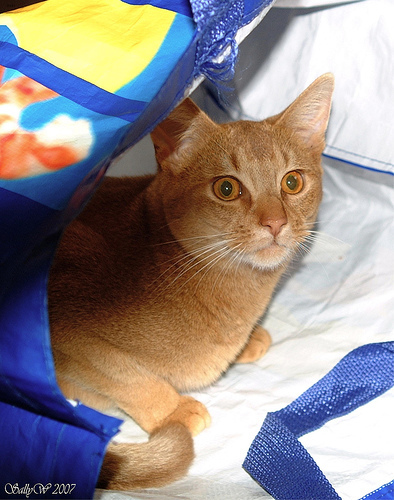

In [3]:
image, mask = dataset[0]
# Show one image
image

In [4]:
# Print the mask Tensor
functional.pil_to_tensor(mask)

tensor([[[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]]], dtype=torch.uint8)

### Define transforms

These transforms augment the training data to improve the robustness of the model.
Use at least 3 different transforms for augmenting the data.
The transforms should augment the image, e.g., distort, crop or rotate.
Transforms that only convert the image to Tensors do not count as augmentation.

See https://pytorch.org/vision/0.11/transforms.html for a list of all transforms.

In [5]:
data_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.ToTensor()
    ]
)

### Define Collate Functions and Dataloaders
Notes:
- You do not have to use collate functions. However they are an easy way to apply methods to and order the data. The data is given as a list of `(image, mask)` tuples, but depending on your implementation, it may be beneficial to load the batches as a tuple of lists, i.e., `([images], [masks])`. The required reordering can be achieved using a collate function.
- Apply the above transforms to the training data. Keep in mind, you should apply the same transforms to the image and mask.
- The model requires a binary mask. Set all pixels that are not the pet in the image to 0.
- You should use a separate collate function for the train and test set. The test set does not need to be transformed, but converted to tensors.

In [6]:
# Collate function for the train set
def collate_train(batch):
    augmented_images = []
    augmented_masks = []

    for image, mask in batch:
        # Set a seed for consistent augmentation between image and mask
        seed = torch.seed()

        # Transform image
        torch.manual_seed(seed)
        image_transformed = data_transforms(image)

        # Convert to binary mask before transformation
        # pet pixels -> 1 & background -> 0
        mask_tensor = functional.pil_to_tensor(mask)
        binary_mask = (mask_tensor != 2).float()
        torch.manual_seed(seed)
        mask_transformed = data_transforms(transforms.ToPILImage()(binary_mask))

        augmented_images.append(image_transformed)
        augmented_masks.append(mask_transformed)

    return augmented_images, augmented_masks

# Collate function for testing
def collate_test(batch):
    images, masks = list(zip(*batch))
    images = [transforms.ToTensor()(image) for image in images]
    masks = [functional.pil_to_tensor(mask) for mask in masks]
    masks = [(mask != 2).float() for mask in masks]
    return images, masks

# Create data loaders for training and testing (using DIFFERENT collate functions!)
# Feel free to use custom hyperparameters
batch_size = 8
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_train,
)
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_test
)

### Example images
To check that the masks and transforms are calculated correctly, plot four images, their masks, the transformed version and the corresponding mask.

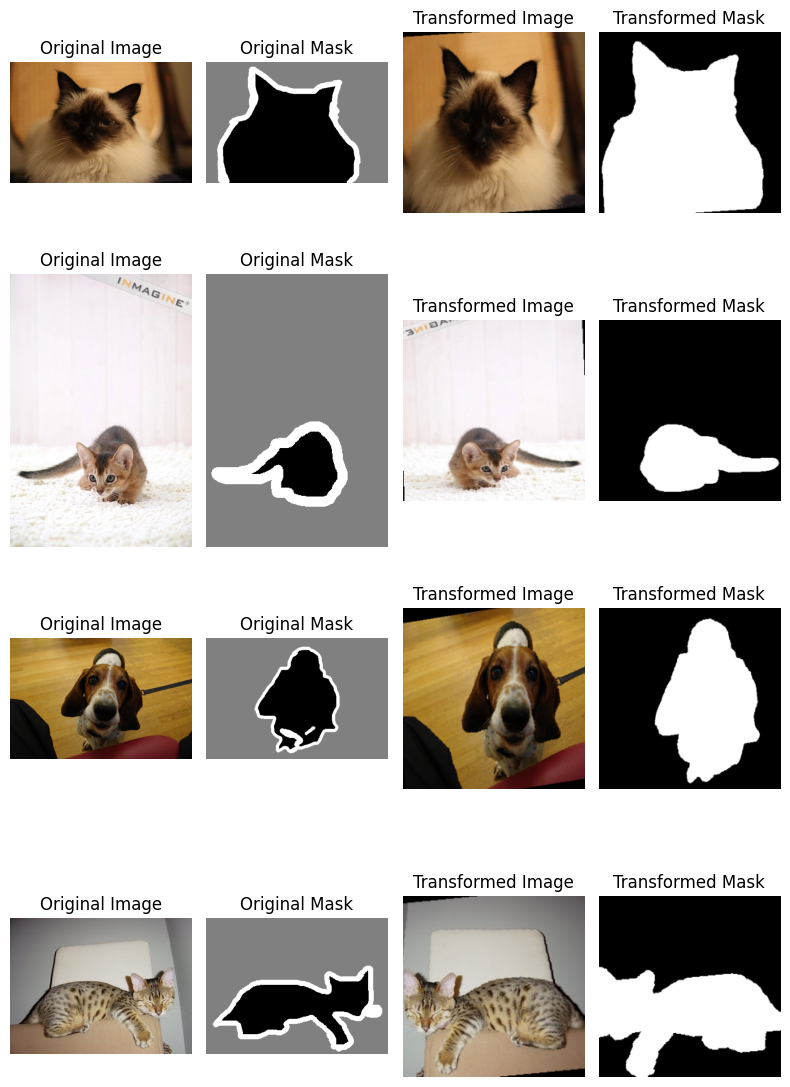

In [7]:
import random

def show_images(original_images, original_targets, transformed_images, transformed_targets, num_images=4):
    fig, axes = plt.subplots(num_images, 4, figsize=(8, num_images * 3))
    for i in range(num_images):
        # Original image
        orig_image = original_images[i]
        orig_image = orig_image.permute(1, 2, 0)
        axes[i, 0].imshow(orig_image)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Original mask
        orig_target = original_targets[i].squeeze()
        axes[i, 1].imshow(orig_target, cmap='gray')
        axes[i, 1].set_title("Original Mask")
        axes[i, 1].axis("off")

        # Transformed image
        trans_image = transformed_images[i]
        trans_image = trans_image.permute(1, 2, 0)
        axes[i, 2].imshow(trans_image)
        axes[i, 2].set_title("Transformed Image")
        axes[i, 2].axis("off")

        # Transformed mask
        trans_target = transformed_targets[i].squeeze()
        axes[i, 3].imshow(trans_target, cmap='gray')
        axes[i, 3].set_title("Transformed Mask")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()
    
# Sample random entries from the dataset
num_images = 4
random_indices = random.sample(range(len(dataset)), num_images)
original_batch = [dataset[i] for i in random_indices]
original_images, original_targets = list(zip(*original_batch))

# Convert original images and targets to tensors
original_images = [transforms.ToTensor()(image) for image in original_images]
original_targets = [transforms.ToTensor()(target) for target in original_targets]

# Apply transformations manually using collate_train function
transformed_images, transformed_targets = collate_train(original_batch)

# Show the images and targets
show_images(original_images, original_targets, transformed_images, transformed_targets, num_images=num_images)

### Introduction to transfer learning

* Transfer learning is an ML methods to **reuse a pre-trained model** on a new problem by exploiting the knowledge gained from a previous task to improve generalization about another similar task.
* Steps:
  1. Select a pre-trained source model
  2. Adapt the source model to create the target model
  3. Fine-tuning: Train source model to achieve the target model
* Strategies for fine-tuning of model:
* There are different **strategies for fine-tuning** the model: You can train the entire model or only some layers and leave the others frozen. Usually, if you have a small dataset and a large number of parameters, you will leave more layers frozen to avoid overfitting. By contrast, if the dataset is large and the number of parameters is small, you can improve your model by training more layers to the new task since overfitting is not an issue.
* **Main benefits:** less training data needed, better initial model, higher learning rate, faster training, higher accuracy after training
* **Example:** In training a classifier to predict the animal species, you could use the knowledge it gained during training to recognize dog breeds.

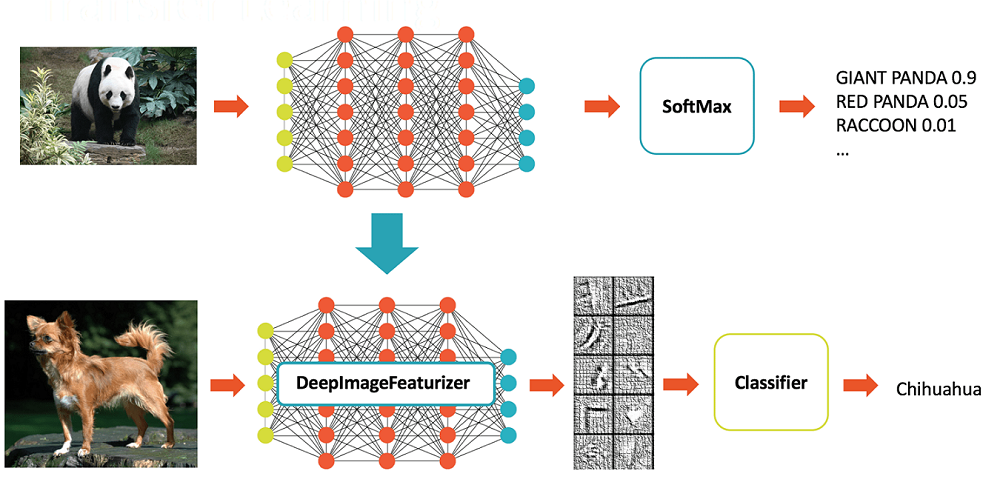

### Defining model and Prediction

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

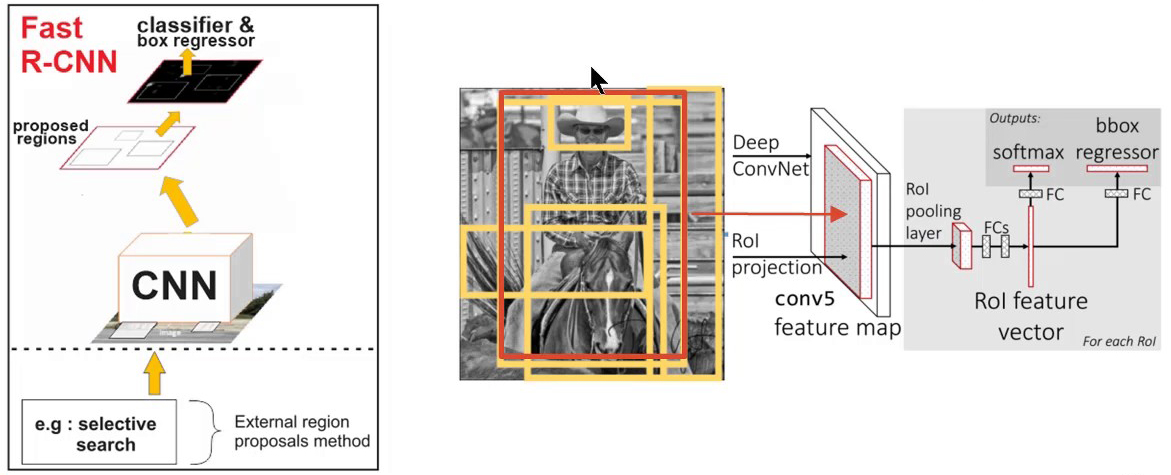


Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

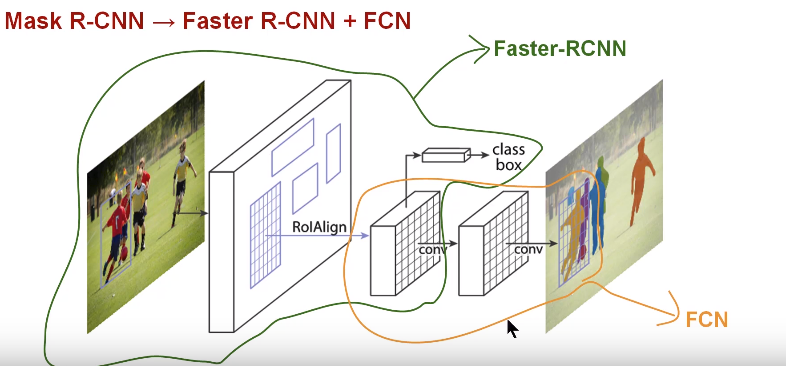


One of popular ways to modify models in torchvision modelzoo when we want to use a pre-trained model, and just finetune the last layer is transfer learning. In our task we want to also compute the segmentation masks, so we will be using Mask R-CNN.

### Define some hyperparameters:
Feel free to test some other options

In [8]:
NUM_CLASSES = 2
HIDDEN_LAYER = 256
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

This part initializes the model, optimizer and learning rate scheduler.

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Model Setup:
# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)

# Get the number of input features for the classifier and replace the head for the box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the head for the box predictor with FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Get the number of input features for the mask classifier and replace the mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# Replace the mask predictor with MaskRCNNPredictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask, HIDDEN_LAYER, NUM_CLASSES
)

# Move the model to the appropriate device
model.to(device)


# Optimizer and Learning Rate Scheduler:
# Create an optimizer with proper lr, momentum, and weight decay
optimizer = torch.optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001
)

# Create a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 211MB/s] 


### Training and evaluation:
Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

Some notes that may or may not be applicable to you:
- You may have to check if a bounding box is valid (i.e., contains foreground and is not 0-width or 0-height)
- Filter out all masks that have invalid bounding boxes

Now, let’s make a function for training each epoch:

In [10]:
def get_boxes(mask):
    pos = mask.squeeze().nonzero(as_tuple=False)
    if pos.numel() == 0:
        # If the mask is empty, return an empty tensor
        return torch.empty((0, 4), dtype=torch.int64)

    x_min = torch.min(pos[:, 1])
    y_min = torch.min(pos[:, 0])
    x_max = torch.max(pos[:, 1])
    y_max = torch.max(pos[:, 0])

    # Ensure bounding box has non-zero width and height
    if (x_max > x_min) and (y_max > y_min):
        return torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.int64)
    else:
        # Invalid bounding box
        return torch.empty((0, 4), dtype=torch.int64)


def train(model, optimizer, dataloader, device, epoch, print_freq=1):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = [image.to(device) for image in images]
        masks = [mask.to(device) for mask in masks]

        valid_images = []
        valid_targets = []

        for i in range(len(images)):
            boxes = get_boxes(masks[i])
            if boxes.numel() == 0:  # Skip invalid masks
                continue

            target = {
                "boxes": boxes.to(device),
                "labels": torch.ones(1, dtype=torch.int64).to(device),
                "masks": masks[i],
                "image_id": i,
            }
            valid_targets.append(target)
            valid_images.append(images[i])

        # Skip batch if no valid targets
        if not valid_targets:
            continue

        images = valid_images
        targets = valid_targets

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimize
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    epoch_loss = running_loss / len(dataloader)

    if epoch % print_freq == 0:
        print(f"Epoch: [{epoch}], Loss: {epoch_loss:.4f}")

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [11]:
from torch.utils.data import Subset
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# subset_dataset = Subset(dataset, list(range(16)))
# subset_dataset_test = Subset(dataset_test, list(range(100)))

# Update the number of epochs
num_epochs = NUM_EPOCHS

batch_size = 8
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_train,
)
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_test
)

# Call the train function
for epoch in range(num_epochs):
    train(model, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()

    # Save the model checkpoint at last epoch
    if epoch == num_epochs - 1:
        torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

Epoch: [0], Loss: 0.2583
Epoch: [1], Loss: 0.1797
Epoch: [2], Loss: 0.1707
Epoch: [3], Loss: 0.1604
Epoch: [4], Loss: 0.1592
Epoch: [5], Loss: 0.1584
Epoch: [6], Loss: 0.1585
Epoch: [7], Loss: 0.1574
Epoch: [8], Loss: 0.1572
Epoch: [9], Loss: 0.1571


In [12]:
model_path = './model_epoch_9.pth'
model.load_state_dict(torch.load(model_path))

/tmp/ipykernel_76/1338023134.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

### Prediction:
Now that training has finished, let's have a look at what it actually predicts in a test image

In [13]:
# Pick one image from the test set
img, _ = dataset_test[0]

# Put the model in evaluation mode
model.eval()

# Convert the PIL Image to a PyTorch tensor
img = transforms.ToTensor()(img)

# Move the image to the appropriate device
img = img.to(device)

# Add a batch dimension
img = img.unsqueeze(0)

# Make predictions
with torch.no_grad():
    prediction = model(img)

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed.

In [14]:
prediction

[{'boxes': tensor([[ 76.9526,  79.3224, 293.6837, 220.8098],
          [170.9200,  52.4369, 298.9271, 213.7529],
          [ 48.5202,  27.9723, 226.8340, 219.7857],
          [  3.1313,  80.3959,  63.9270, 155.9678],
          [ 29.6643,  83.1354,  59.9405, 129.8816]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9962, 0.2156, 0.1950, 0.0932, 0.0516], device='cuda:0'),
  'masks': tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            ...,
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.9371e-05,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0

Let's inspect and visualize the image and the top predicted segmentation masks.

And let's now visualize the top predicted segmentation mask.

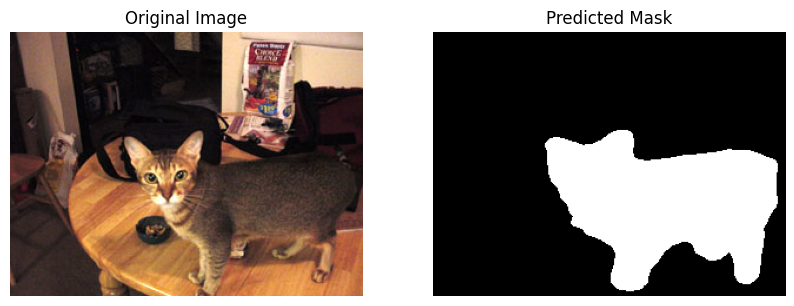

In [15]:
# Visualize the top predicted segmentation mask
def visualize_prediction(image, prediction, threshold=0.5):
	plt.figure(figsize=(10, 5))

	# Original image
	plt.subplot(1, 2, 1)
	plt.imshow(image.permute(1, 2, 0).cpu())
	plt.title("Original Image")
	plt.axis("off")

	# Predicted mask
	plt.subplot(1, 2, 2)
	mask = prediction[0]['masks'][0, 0].cpu().numpy()
	mask = mask > threshold
	plt.imshow(mask, cmap='gray')
	plt.title("Predicted Mask")
	plt.axis("off")

	plt.show()

visualize_prediction(img.squeeze(), prediction)

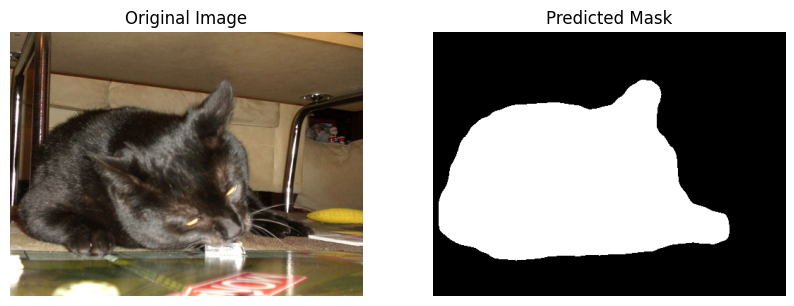

In [16]:
# Pick a random image from the test set
random_idx = random.randint(0, len(dataset_test) - 1)
img, _ = dataset_test[random_idx]

img = transforms.ToTensor()(img)

img = img.to(device)

img = img.unsqueeze(0)

with torch.no_grad():
    prediction = model(img)

visualize_prediction(img.squeeze(), prediction)

For some other examples visualize original image and all predicted segmentation masks.

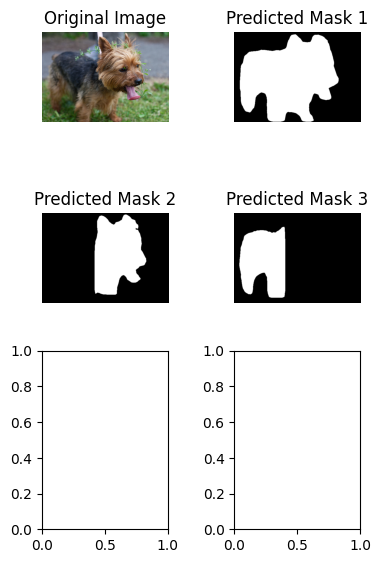

In [44]:
# Visualize the original image and all predicted segmentation masks
def visualize_all_predictions(image, prediction, threshold=0.5):
    num_masks = len(prediction[0]['masks'])
    num_cols = 2
    num_rows = (num_masks + num_cols - 1) // num_cols + 1  # +1 for the original image row

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

    # Original image
    axes[0, 0].imshow(image.permute(1, 2, 0).cpu())
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis("off")

    for j in range(1, num_cols):
        axes[0, j].axis("off")

    # Predicted masks
    for i in range(num_masks):
        row = (i + 1) // num_cols
        col = (i + 1) % num_cols
        mask = prediction[0]['masks'][i, 0].cpu().numpy()
        mask = mask > threshold
        axes[row, col].imshow(mask, cmap='gray')
        axes[row, col].set_title(f"Predicted Mask {i + 1}")
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

# Pick a random image from the test set
random_idx = random.randint(0, len(dataset_test) - 1)
img, _ = dataset_test[random_idx]

img = transforms.ToTensor()(img)

img = img.to(device)

img = img.unsqueeze(0)

with torch.no_grad():
    prediction = model(img)

visualize_all_predictions(img.squeeze(), prediction)

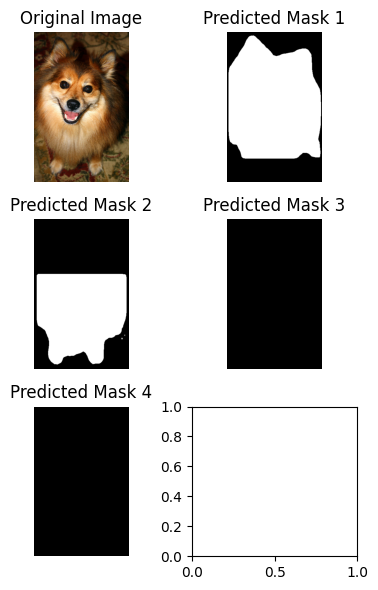

In [38]:
# Pick a random image from the test set
random_idx = random.randint(0, len(dataset_test) - 1)
img, _ = dataset_test[random_idx]

img = transforms.ToTensor()(img)

img = img.to(device)

img = img.unsqueeze(0)

with torch.no_grad():
    prediction = model(img)

visualize_all_predictions(img.squeeze(), prediction)

### Evaluation
In semantic segmentation tasks, you want to assess the quality of pixel-wise predictions made by your model. This includes metrics like Intersection over Union (IoU), Dice Coefficient, and Pixel Accuracy.

We recommend using [torchmetrics](https://torchmetrics.readthedocs.io/en/v0.9.3/).

In [39]:
# 1. Calculate and print the Intersection over Union (IoU) for each class and the mean IoU.
# 2. Calculate and print the Dice Coefficient for each class and the mean Dice Coefficient.
# 3. Compute and print the Pixel Accuracy.

import torchmetrics

# Initialize metric objects
iou_metric = torchmetrics.JaccardIndex(num_classes=NUM_CLASSES, task="binary").to(device)
dice_metric = torchmetrics.Dice(num_classes=NUM_CLASSES).to(device)
accuracy_metric = torchmetrics.Accuracy(num_classes=NUM_CLASSES, task="binary").to(device)

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for images, masks in data_loader_test:
        images = [image.to(device) for image in images]
        masks = [mask.to(device) for mask in masks]

        # Get the model's prediction
        predictions = model(images)
        for pred, mask in zip(predictions, masks):
            # Get first mask
            pred_mask = pred['masks'][0, 0] > 0.5
            
            # Add channel dimension
            pred_mask = pred_mask.unsqueeze(0)
            # Convert to long
            mask = mask.long()

            # Update metrics
            iou_metric.update(pred_mask, mask)
            dice_metric.update(pred_mask.squeeze(), mask)
            accuracy_metric.update(pred_mask, mask)

iou = iou_metric.compute()
dice = dice_metric.compute()
accuracy = accuracy_metric.compute()

print(f"Mean IoU: {iou.mean().item():.4f}")
print(f"Mean Dice Coefficient: {dice.mean().item():.4f}")
print(f"Pixel Accuracy: {accuracy.item():.4f}")

Mean IoU: 0.8919
Mean Dice Coefficient: 0.9531
Pixel Accuracy: 0.9531
